# Idea

Take two sequences with a very high sequence similarity and mutate X into Y and Y into X. Consider the average mutational effect over the entire sequence. Is it the same or is one worde than the other? 

In [1]:
import pandas as pd
import sys 
sys.path.append('../vespag')

from parse.vep_scores import load_vespag_scores_from_folder, load_dms_scores_from_folder, load_fasta_file
from tqdm import tqdm

In [2]:
# load the PLA2 dataset 
pla2_fasta_file = '../data/20231031_PLA2.fasta'

pla2_sequences = load_fasta_file(pla2_fasta_file)
pla2_sequences['sequence'] = pla2_sequences['sequence'].astype(str)
pla2_sequences['length'] = pla2_sequences['sequence'].apply(len)
pla2_sequences.head()

,id,sequence,length
0,P00622_caudoxin_Bitis_caudalis,NLIQFGNMISAMTGKSSLAYASYGCYCGWGGKGQPKDDTDRCCFVH...,121
1,DQ090656_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,122
2,JZ980952_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,122
3,DQ090660_1_Daboia_russelii,NLFQFARMIDAKQEAFSFFKYISYGCYCGWGGQGTPKDASDRCCFV...,122
4,DQ365975_1_Daboia_russelii,NLFQFARMIDAKQEAFSFFKYISYGCYCGWGGQGTPKDASDRCCFV...,122


In [3]:
vespag_results = load_vespag_scores_from_folder('/mnt/f/nicole/pla2_vespag/')
vespag_results['vespag'] = -vespag_results['vespag']
vespag_results['mutation_effect'] = (vespag_results['vespag'] - vespag_results['vespag'].min()) / (vespag_results['vespag'].max() - vespag_results['vespag'].min())
vespag_results.head()

Loading VespaG scores: 100%|██████████| 524/524 [00:04<00:00, 115.74file/s]


,residue,mutation,vespag,id,mutation_effect
0,N1,N1A,2.552438,AY355170_1_sistruxin_B_Sistrurus_tergeminus,0.364656
1,N1,N1Y,3.675682,AY355170_1_sistruxin_B_Sistrurus_tergeminus,0.493063
2,N1,N1W,4.004534,AY355170_1_sistruxin_B_Sistrurus_tergeminus,0.530656
3,N1,N1V,3.488040,AY355170_1_sistruxin_B_Sistrurus_tergeminus,0.471612
4,N1,N1T,2.369666,AY355170_1_sistruxin_B_Sistrurus_tergeminus,0.343762


In [4]:
# get the sequence with the highest average vespag scores 
vespag_results = vespag_results.sort_values('mutation_effect', ascending=False)
vespag_results.head()

,residue,mutation,vespag,id,mutation_effect
361629,D41,D41W,8.110158,sPybiF,1.000000
361636,D41,D41M,8.022312,sPybiF,0.989958
291443,D41,D41W,8.006468,sCrhoAF,0.988146
1143097,D41,D41P,8.000409,sPsteF,0.987454
291441,D41,D41P,7.991830,sCrhoAF,0.986473


In [5]:
def get_differing_residues(pla2_sequences, sequence_id):
    """
    Couldn't come up with a better name for a function. 
    
    Determines the sequences that the sequence can mutate into (same length as sequence).
    Determines the (number of) residues that differ between the sequence and the sequences that the sequence can mutate into.
    """
    sequence_length = pla2_sequences[pla2_sequences['id'] == sequence_id]['length'].values[0]
    sequence = pla2_sequences[pla2_sequences['id'] == sequence_id]['sequence'].values[0]
    family_sequences = pla2_sequences[(pla2_sequences['length'] == sequence_length) & (pla2_sequences['id'] != sequence_id)].copy()
    family_sequences['n_different'] = family_sequences.apply(lambda x: sum([1 for i in range(len(x['sequence'])) if x['sequence'][i] != sequence[i]]), axis=1)
    family_sequences['differing_residues'] = family_sequences.apply(lambda x: [i+1 for i in range(len(x['sequence'])) if x['sequence'][i] != sequence[i]], axis=1)
    family_sequences = family_sequences.sort_values('n_different')
    return family_sequences

dfs = []
for idx, row in tqdm(pla2_sequences.iterrows(), total=pla2_sequences.shape[0], desc='Calculating differing residues'):
    try:
        df = get_differing_residues(pla2_sequences, row['id'])
        df['wildtype_id'] = row['id']
        df['wildtype_sequence'] = row['sequence']
        df = df.rename(columns={'id': 'mutant_id', 'sequence': 'mutant_sequence'})
        dfs.append(df[df.n_different <= 10])
    except:
        pass

dfs = pd.concat(dfs)
dfs.head()

Calculating differing residues: 100%|██████████| 524/524 [00:41<00:00, 12.55it/s]


,mutant_id,mutant_sequence,length,n_different,differing_residues,wildtype_id,wildtype_sequence
2,JZ980952_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,122,1,[67],DQ090656_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...
3,DQ090660_1_Daboia_russelii,NLFQFARMIDAKQEAFSFFKYISYGCYCGWGGQGTPKDASDRCCFV...,122,4,"[8, 40, 67, 77]",DQ090656_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...
4,DQ365975_1_Daboia_russelii,NLFQFARMIDAKQEAFSFFKYISYGCYCGWGGQGTPKDASDRCCFV...,122,5,"[8, 40, 67, 77, 99]",DQ090656_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...
1,DQ090656_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,122,1,[67],JZ980952_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...
3,DQ090660_1_Daboia_russelii,NLFQFARMIDAKQEAFSFFKYISYGCYCGWGGQGTPKDASDRCCFV...,122,3,"[8, 40, 77]",JZ980952_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...


In [6]:
# build the mutations from c atrox to other sequences
def build_mutation(differing_residues, wildtype_sequence, mutant_sequence):
    mutations = []
    inverted_mutation = []
    for r in differing_residues:
        mutations.append(f'{wildtype_sequence[r-1]}{r}{mutant_sequence[r-1]}')
        inverted_mutation.append(f'{mutant_sequence[r-1]}{r}{wildtype_sequence[r-1]}')
    return mutations, inverted_mutation

dfs['mutations'], dfs['inverted_mutations'] = zip(*dfs.apply(lambda x: build_mutation(x['differing_residues'], x['wildtype_sequence'], x['mutant_sequence']), axis=1))
dfs.head()

,mutant_id,mutant_sequence,length,n_different,differing_residues,wildtype_id,wildtype_sequence,mutations,inverted_mutations
2,JZ980952_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,122,1,[67],DQ090656_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,[G67S],[S67G]
3,DQ090660_1_Daboia_russelii,NLFQFARMIDAKQEAFSFFKYISYGCYCGWGGQGTPKDASDRCCFV...,122,4,"[8, 40, 67, 77]",DQ090656_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,"[L8M, T40S, G67S, N77T]","[M8L, S40T, S67G, T77N]"
4,DQ365975_1_Daboia_russelii,NLFQFARMIDAKQEAFSFFKYISYGCYCGWGGQGTPKDASDRCCFV...,122,5,"[8, 40, 67, 77, 99]",DQ090656_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,"[L8M, T40S, G67S, N77T, N99D]","[M8L, S40T, S67G, T77N, D99N]"
1,DQ090656_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,122,1,[67],JZ980952_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,[S67G],[G67S]
3,DQ090660_1_Daboia_russelii,NLFQFARMIDAKQEAFSFFKYISYGCYCGWGGQGTPKDASDRCCFV...,122,3,"[8, 40, 77]",JZ980952_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,"[L8M, T40S, N77T]","[M8L, S40T, T77N]"


In [12]:
tqdm.pandas()

# calculate the mean effect of the mutations to go from c atrox to other sequences and the other way around 
def get_mutation_effects(vespag_scores, wildtye_id, mutations, mutant_id, inverted_mutations):
    # find the mutations for the correct sequence
    mutation_effects = list(vespag_scores[(vespag_scores['mutation'].isin(mutations)) & (vespag_scores['id'] == wildtye_id)].mutation_effect.round(4))
    inverted_mutation_effects = list(vespag_scores[(vespag_scores['mutation'].isin(inverted_mutations)) & (vespag_scores['id'] == mutant_id)].mutation_effect.round(4))
    return mutation_effects, inverted_mutation_effects

dfs['mutation_effects'], dfs['inverted_mutation_effects'] = zip(*dfs.progress_apply(
    lambda x: get_mutation_effects(vespag_results, x['wildtype_id'], x['mutations'], x['mutant_id'], x['inverted_mutations']),
    axis=1
))
dfs.head()

100%|██████████| 3472/3472 [23:00<00:00,  2.51it/s]


,mutant_id,mutant_sequence,length,n_different,differing_residues,wildtype_id,wildtype_sequence,mutations,inverted_mutations,mutation_effects,inverted_mutation_effects
2,JZ980952_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,122,1,[67],DQ090656_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,[G67S],[S67G],[0.1379],[0.3423]
3,DQ090660_1_Daboia_russelii,NLFQFARMIDAKQEAFSFFKYISYGCYCGWGGQGTPKDASDRCCFV...,122,4,"[8, 40, 67, 77]",DQ090656_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,"[L8M, T40S, G67S, N77T]","[M8L, S40T, S67G, T77N]","[0.4013, 0.2869, 0.2501, 0.1379]","[0.3487, 0.3123, 0.2664, 0.2524]"
4,DQ365975_1_Daboia_russelii,NLFQFARMIDAKQEAFSFFKYISYGCYCGWGGQGTPKDASDRCCFV...,122,5,"[8, 40, 67, 77, 99]",DQ090656_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,"[L8M, T40S, G67S, N77T, N99D]","[M8L, S40T, S67G, T77N, D99N]","[0.4013, 0.3966, 0.2869, 0.2501, 0.1379]","[0.3509, 0.3152, 0.2673, 0.2562, 0.2385]"
1,DQ090656_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,122,1,[67],JZ980952_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,[S67G],[G67S],[0.3423],[0.1379]
3,DQ090660_1_Daboia_russelii,NLFQFARMIDAKQEAFSFFKYISYGCYCGWGGQGTPKDASDRCCFV...,122,3,"[8, 40, 77]",JZ980952_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,"[L8M, T40S, N77T]","[M8L, S40T, T77N]","[0.3981, 0.2855, 0.2474]","[0.3123, 0.2664, 0.2524]"


In [14]:
dfs['mean_mutation_effect'] = dfs['mutation_effects'].apply(lambda x: sum(x) / len(x) if len(x) > 0 else None)
dfs['mean_inverted_mutation_effect'] = dfs['inverted_mutation_effects'].apply(lambda x: sum(x) / len(x) if len(x) > 0 else None)
dfs.head()

,mutant_id,mutant_sequence,length,n_different,differing_residues,wildtype_id,wildtype_sequence,mutations,inverted_mutations,mutation_effects,inverted_mutation_effects,mean_mutation_effect,mean_inverted_mutation_effect
2,JZ980952_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,122,1,[67],DQ090656_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,[G67S],[S67G],[0.1379],[0.3423],0.137900,0.342300
3,DQ090660_1_Daboia_russelii,NLFQFARMIDAKQEAFSFFKYISYGCYCGWGGQGTPKDASDRCCFV...,122,4,"[8, 40, 67, 77]",DQ090656_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,"[L8M, T40S, G67S, N77T]","[M8L, S40T, S67G, T77N]","[0.4013, 0.2869, 0.2501, 0.1379]","[0.3487, 0.3123, 0.2664, 0.2524]",0.269050,0.294950
4,DQ365975_1_Daboia_russelii,NLFQFARMIDAKQEAFSFFKYISYGCYCGWGGQGTPKDASDRCCFV...,122,5,"[8, 40, 67, 77, 99]",DQ090656_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,"[L8M, T40S, G67S, N77T, N99D]","[M8L, S40T, S67G, T77N, D99N]","[0.4013, 0.3966, 0.2869, 0.2501, 0.1379]","[0.3509, 0.3152, 0.2673, 0.2562, 0.2385]",0.294560,0.285620
1,DQ090656_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,122,1,[67],JZ980952_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,[S67G],[G67S],[0.3423],[0.1379],0.342300,0.137900
3,DQ090660_1_Daboia_russelii,NLFQFARMIDAKQEAFSFFKYISYGCYCGWGGQGTPKDASDRCCFV...,122,3,"[8, 40, 77]",JZ980952_1_Daboia_siamensis,NLFQFARLIDAKQEAFSFFKYISYGCYCGWGGQGTPKDATDRCCFV...,"[L8M, T40S, N77T]","[M8L, S40T, T77N]","[0.3981, 0.2855, 0.2474]","[0.3123, 0.2664, 0.2524]",0.310333,0.277033


In [17]:
dfs['diff_mean'] = (dfs['mean_mutation_effect'] - dfs['mean_inverted_mutation_effect']).abs()
dfs = dfs.sort_values('diff_mean', ascending=False)
dfs.to_csv('summary_symmetrical_mutations.csv', index=False, sep='\t')

In [1]:
import pandas as pd

In [16]:
dfs = pd.read_csv('summary_symmetrical_mutations.csv', sep='\t')
# Create a new column with the sorted pair of IDs
dfs['id_pair'] = dfs.apply(lambda row: tuple(sorted([row['wildtype_id'], row['mutant_id']])), axis=1)

# Drop duplicates based on the id_pair column, then drop the helper column
dfs = dfs.drop_duplicates(subset=['id_pair']).drop(columns=['id_pair'])

dfs.head()

,mutant_id,mutant_sequence,length,n_different,differing_residues,wildtype_id,wildtype_sequence,mutations,inverted_mutations,mutation_effects,inverted_mutation_effects,mean_mutation_effect,mean_inverted_mutation_effect,diff_mean
0,GDAZ01000058_1_Agkistrodon_piscivorus,SVLELGKMILQETGKNAITSYGSYGCNFGWGHRGQPKDATDRCCFV...,121,1,[28],EV854871_1_Agkistrodon_piscivorus,SVLELGKMILQETGKNAITSYGSYGCNCGWGHRGQPKDATDRCCFV...,['C28F'],['F28C'],[0.7629],[0.2565],0.7629,0.2565,0.5064
2,AJ580271_1_Vipera_ammodytes_montandoni,SVIEFGKMIQEETDKNPITSYSFYGCHCGLGNKGKPKGATDRCCFV...,122,1,[38],AJ580267_1_Vipera_ammodytes_montandoni,SVIEFGKMIQEETDKNPITSYSFYGCHCGLGNKGKPKDATDRCCFV...,['D38G'],['G38D'],[0.7072],[0.2873],0.7072,0.2873,0.4199
4,AJ580213_1_Vipera_ammodytes_ruffoi,NLYQFGNMIFKMTKKSALLSYSNYGCYCGWGGKGKPQDATDRCCFV...,121,1,[92],AJ580210_1_Vipera_aspis_aspis,NLYQFGNMIFKMTKKSALLSYSNYGCYCGWGGKGKPQDATDRCCFV...,['A92E'],['E92A'],[0.6357],[0.2177],0.6357,0.2177,0.4180
6,EV854871_1_Agkistrodon_piscivorus,SVLELGKMILQETGKNAITSYGSYGCNCGWGHRGQPKDATDRCCFV...,121,1,[100],GDAZ01000057_1_Agkistrodon_piscivorus,SVLELGKMILQETGKNAITSYGSYGCNCGWGHRGQPKDATDRCCFV...,['P100L'],['L100P'],[0.1584],[0.5673],0.1584,0.5673,0.4089
8,GR950539_1_Echis_pyramidum_leakeyi,SVIELGKMIIQLTNKTPASYVSYGCFCGGGDKGKPKDATDRCCFVH...,121,1,[25],GR951187_1_Echis_pyramidum_leakeyi,SVIELGKMIIQLTNKTPASYVSYGRFCGGGDKGKPKDATDRCCFVH...,['R25C'],['C25R'],[0.2857],[0.6752],0.2857,0.6752,0.3895


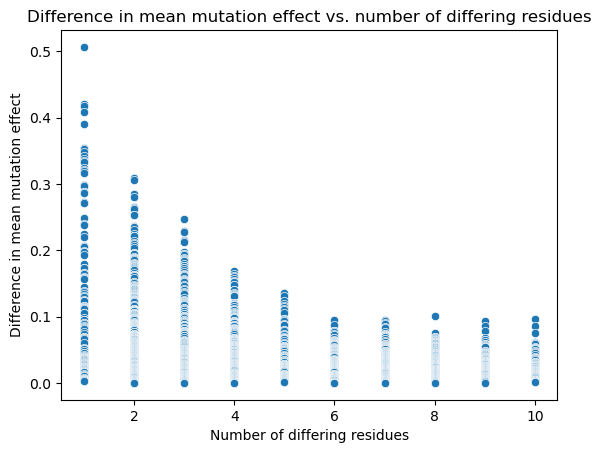

In [17]:
# plot the number of differing residues against the diff_mean
import matplotlib.pyplot as plt 
import seaborn as sns 

sns.scatterplot(data=dfs, x='n_different', y='diff_mean', color='tab:blue')
plt.title('Difference in mean mutation effect vs. number of differing residues')
plt.xlabel('Number of differing residues')
plt.ylabel('Difference in mean mutation effect')
plt.show()

In [42]:
threshold = 0.3
large_differing_mutations = dfs[dfs.diff_mean > threshold].copy()
import ast
large_differing_mutations['relatives'] = large_differing_mutations.apply(
    lambda row: f"{row['wildtype_id']} - {row['mutant_id']} ({', '.join(ast.literal_eval(row['mutations']))})",
    axis=1
)
large_differing_mutations.head()

,mutant_id,mutant_sequence,length,n_different,differing_residues,wildtype_id,wildtype_sequence,mutations,inverted_mutations,mutation_effects,inverted_mutation_effects,mean_mutation_effect,mean_inverted_mutation_effect,diff_mean,relatives
0,GDAZ01000058_1_Agkistrodon_piscivorus,SVLELGKMILQETGKNAITSYGSYGCNFGWGHRGQPKDATDRCCFV...,121,1,[28],EV854871_1_Agkistrodon_piscivorus,SVLELGKMILQETGKNAITSYGSYGCNCGWGHRGQPKDATDRCCFV...,['C28F'],['F28C'],[0.7629],[0.2565],0.7629,0.2565,0.5064,EV854871_1_Agkistrodon_piscivorus - GDAZ010000...
2,AJ580271_1_Vipera_ammodytes_montandoni,SVIEFGKMIQEETDKNPITSYSFYGCHCGLGNKGKPKGATDRCCFV...,122,1,[38],AJ580267_1_Vipera_ammodytes_montandoni,SVIEFGKMIQEETDKNPITSYSFYGCHCGLGNKGKPKDATDRCCFV...,['D38G'],['G38D'],[0.7072],[0.2873],0.7072,0.2873,0.4199,AJ580267_1_Vipera_ammodytes_montandoni - AJ580...
4,AJ580213_1_Vipera_ammodytes_ruffoi,NLYQFGNMIFKMTKKSALLSYSNYGCYCGWGGKGKPQDATDRCCFV...,121,1,[92],AJ580210_1_Vipera_aspis_aspis,NLYQFGNMIFKMTKKSALLSYSNYGCYCGWGGKGKPQDATDRCCFV...,['A92E'],['E92A'],[0.6357],[0.2177],0.6357,0.2177,0.4180,AJ580210_1_Vipera_aspis_aspis - AJ580213_1_Vip...
6,EV854871_1_Agkistrodon_piscivorus,SVLELGKMILQETGKNAITSYGSYGCNCGWGHRGQPKDATDRCCFV...,121,1,[100],GDAZ01000057_1_Agkistrodon_piscivorus,SVLELGKMILQETGKNAITSYGSYGCNCGWGHRGQPKDATDRCCFV...,['P100L'],['L100P'],[0.1584],[0.5673],0.1584,0.5673,0.4089,GDAZ01000057_1_Agkistrodon_piscivorus - EV8548...
8,GR950539_1_Echis_pyramidum_leakeyi,SVIELGKMIIQLTNKTPASYVSYGCFCGGGDKGKPKDATDRCCFVH...,121,1,[25],GR951187_1_Echis_pyramidum_leakeyi,SVIELGKMIIQLTNKTPASYVSYGRFCGGGDKGKPKDATDRCCFVH...,['R25C'],['C25R'],[0.2857],[0.6752],0.2857,0.6752,0.3895,GR951187_1_Echis_pyramidum_leakeyi - GR950539_...


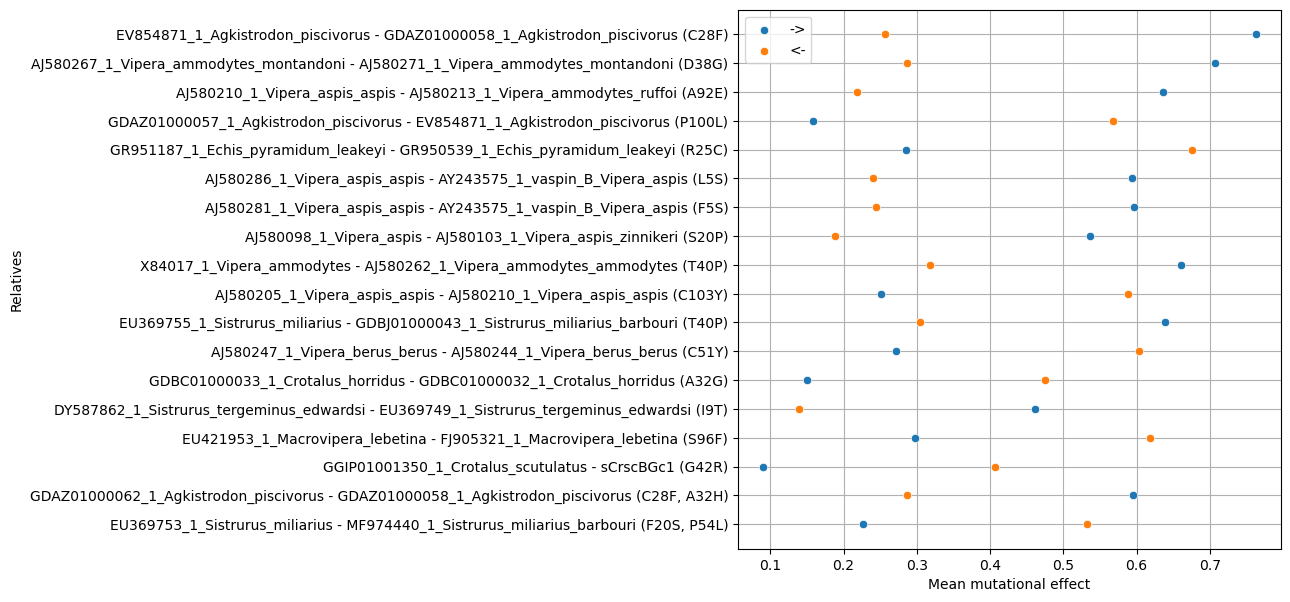

In [47]:
# scatterplot of these mean effects
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(7, 7))
sns.scatterplot(y='relatives', x='mean_mutation_effect', data=large_differing_mutations, label='->', zorder=2)
sns.scatterplot(y='relatives', x='mean_inverted_mutation_effect', data=large_differing_mutations, label='<-', zorder=2)
plt.xlabel('Mean mutational effect')
plt.ylabel('Relatives')
plt.legend()
plt.grid(zorder=0)
plt.show()